## Observations and Insights 

1. Sometimes tumor volume steadily drops while other times it trends down while still spiking up some. I created another graph so I could see multpile results on top of each other to further view the phenomenon.
2. As the weight of a mouse increases, so does the mean tumor size according to the last graph. I wondered if that effect would be less pronounced if final tumor volume was used instead of mean tumor volume so I reworked the graph to show both. To my surprise, final tumor volume actually increases faster as mouse weight increases, implying that higher weight may lead to reduced response to the trial med.
3. The drug regimen we analyze most, Capomulin, is also the regimen with the most measurements taken, which is quite fitting. The more data the better.

# Start of Analysis

In [54]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from scipy.stats import linregress
from functools import reduce
import random
from matplotlib.lines import Line2D
mouse_metadata_path = "data/mouseData.csv"
study_results_path = "data/studyResults.csv"
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)
data = pd.merge(mouse_metadata, study_results, how='outer', on="mouse_id")
data

,mouse_id,drug_regimen,sex,age_months,weight_g,timepoint,tumor_volume_mm3,metastatic_sites
0,a203,Infubinol,Female,20,23,0,45.000000,0
1,a203,Infubinol,Female,20,23,5,48.508468,0
2,a203,Infubinol,Female,20,23,10,51.852437,1
3,a203,Infubinol,Female,20,23,15,52.777870,1
4,a203,Infubinol,Female,20,23,20,55.173336,1
...,...,...,...,...,...,...,...,...
1888,z969,Naftisol,Male,9,30,25,63.145652,2
1889,z969,Naftisol,Male,9,30,30,65.841013,3
1890,z969,Naftisol,Male,9,30,35,69.176246,4
1891,z969,Naftisol,Male,9,30,40,70.314904,4


In [2]:
print(f'There are {data["mouse_id"].nunique()} mice.')

There are 249 mice.


In [3]:
duplicate_mice = data[data.duplicated(['mouse_id','timepoint'])]['mouse_id'].values[0]
print(f"'{duplicate_mice}' is the duplicate mice ID.")

'g989' is the duplicate mice ID.


In [4]:
duplicate_mice_data = data.query('mouse_id == @duplicate_mice', inplace = False)
duplicate_mice_data

,mouse_id,drug_regimen,sex,age_months,weight_g,timepoint,tumor_volume_mm3,metastatic_sites
586,g989,Propriva,Female,21,26,0,45.000000,0
587,g989,Propriva,Female,21,26,0,45.000000,0
588,g989,Propriva,Female,21,26,5,48.786801,0
589,g989,Propriva,Female,21,26,5,47.570392,0
590,g989,Propriva,Female,21,26,10,51.745156,0
591,g989,Propriva,Female,21,26,10,49.880528,0
592,g989,Propriva,Female,21,26,15,51.325852,1
593,g989,Propriva,Female,21,26,15,53.442020,0
594,g989,Propriva,Female,21,26,20,55.326122,1
595,g989,Propriva,Female,21,26,20,54.657650,1


In [5]:
data = data.drop(data[data['mouse_id']==duplicate_mice].index)

In [6]:
print(f'There are now {data["mouse_id"].nunique()} mice.')

There are now 248 mice.


## Summary Statistics

In [7]:
mean=data.groupby(by=["drug_regimen"]).mean()["tumor_volume_mm3"]
median=data.groupby(by=["drug_regimen"]).median()["tumor_volume_mm3"]
variance=data.groupby(by=["drug_regimen"]).var()["tumor_volume_mm3"]
standard_deviation=data.groupby(by=["drug_regimen"]).std()["tumor_volume_mm3"]
sem=data.groupby(by=["drug_regimen"]).sem()["tumor_volume_mm3"]
summary_dataframes = [mean, median, variance, standard_deviation, sem]
summary_statistics = reduce(lambda  left,right: pd.merge(left,right,on=['drug_regimen'], how='outer'), summary_dataframes)
summary_statistics.index.names = ['Drug Regimen']
summary_statistics.columns = ['Mean','Median','Variance','Std Deviation','SEM']
summary_statistics

,Mean,Median,Variance,Std Deviation,SEM
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [8]:
summary_statistics_agg=data.groupby('drug_regimen').agg({'tumor_volume_mm3': ['mean','median','var','std','sem']})
summary_statistics_agg.index.names = ['Drug Regimen']
summary_statistics_agg.columns = ['Mean','Median','Variance','Std Deviation','SEM']
summary_statistics_agg

,Mean,Median,Variance,Std Deviation,SEM
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


## Bar and Pie Charts

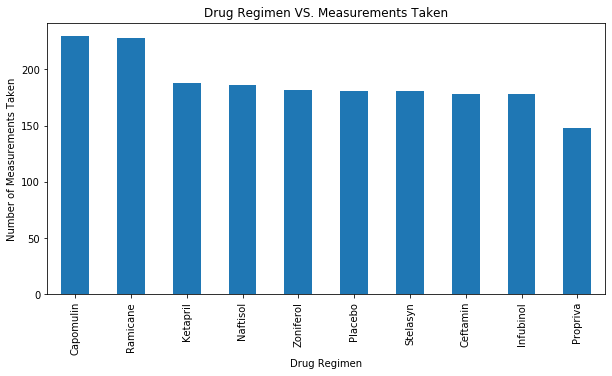

In [9]:
measurements=data["drug_regimen"].value_counts()
measurements.plot(kind="bar", figsize=(10,5), width=.5, title='Drug Regimen VS. Measurements Taken')
plt.xlabel("Drug Regimen")
plt.ylabel("Number of Measurements Taken")
plt.show()

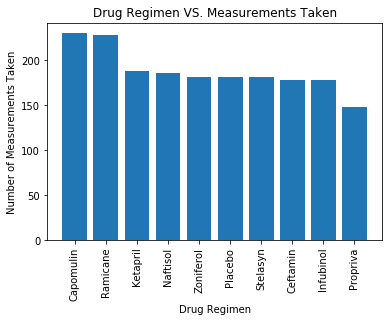

In [10]:
measurements_pyplot = pd.DataFrame(data=measurements)
measurements_pyplot.reset_index(inplace = True)
plt.bar(measurements_pyplot.iloc[:,0], measurements_pyplot.iloc[:,1], color='#2077b4')
plt.xticks([value for value in measurements_pyplot.iloc[:,0]], rotation="vertical")
plt.xlabel("Drug Regimen")
plt.ylabel("Number of Measurements Taken")
plt.title("Drug Regimen VS. Measurements Taken")
plt.show()

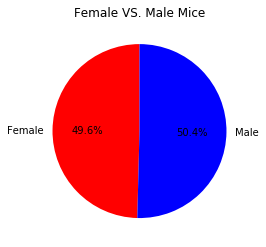

In [11]:
gender_distribution=data.groupby(['mouse_id','sex']).min()
gender_distribution.reset_index(inplace = True)
gender_distribution=gender_distribution.groupby('sex').count()['mouse_id']
gender_distribution_dataframe=pd.DataFrame(gender_distribution)
gender_distribution_dataframe.plot(kind='pie', y='mouse_id', title='Female VS. Male Mice', autopct='%1.1f%%', colors=['red','blue'], startangle=90, legend=False)
plt.ylabel('')
plt.show()

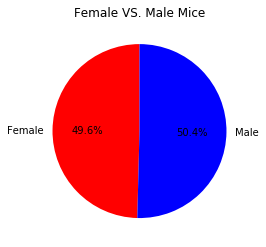

In [12]:
gender_distribution_dataframe = gender_distribution_dataframe.reset_index()
plt.pie(gender_distribution_dataframe.iloc[:,1], labels=gender_distribution_dataframe.iloc[:,0], colors=['red','blue'], autopct="%1.1f%%", shadow=False, startangle=90)
plt.title("Female VS. Male Mice")
plt.show()

## Quartiles, Outliers and Boxplots

In [13]:
treatments=["Capomulin", "Ramicane", "Infubinol", "Ceftamin"]
last_timepoint=pd.DataFrame(data.groupby(['mouse_id']).max()['timepoint'])
last_tumor_volume=pd.merge(last_timepoint, data, on=['timepoint',"mouse_id"], how='inner')
last_tumor_volume_four = last_tumor_volume[last_tumor_volume['drug_regimen'].isin(treatments)]
last_tumor_volume_four

,timepoint,mouse_id,drug_regimen,sex,age_months,weight_g,tumor_volume_mm3,metastatic_sites
0,45,a203,Infubinol,Female,20,23,67.973419,2
1,45,a251,Infubinol,Female,21,25,65.525743,1
3,45,a275,Ceftamin,Female,20,28,62.999356,3
6,45,a411,Ramicane,Male,3,22,38.407618,1
7,45,a444,Ramicane,Female,10,25,43.047543,0
...,...,...,...,...,...,...,...,...
238,45,y769,Ceftamin,Female,6,27,68.594745,4
239,45,y793,Capomulin,Male,17,17,31.896238,2
240,45,y865,Ceftamin,Male,23,26,64.729837,3
244,45,z578,Ramicane,Male,11,16,30.638696,0


In [14]:
top_four = {}
top_four_outliers = {}
for treatment in treatments:
    current_treatment=last_tumor_volume_four.loc[last_tumor_volume_four['drug_regimen'] == treatment, "tumor_volume_mm3"]
    top_four[treatment] = last_tumor_volume.query('drug_regimen == @treatment', inplace = False)
    quantiles=current_treatment.quantile([.25,.5,.75])
    outliers=current_treatment.loc[(current_treatment <quantiles[0.25]) | (current_treatment>quantiles[0.75])]    
    top_four_outliers[treatment] = {'outliers': outliers, 'lower_cap': quantiles[0.25], 'upper_cap': quantiles[0.75]}
for treatment in treatments:
    print('Treatment:')
    print(treatment)
    print('Outliers:')
    print(top_four_outliers[treatment]['outliers'])
    print('Lower Cap:')
    print(top_four_outliers[treatment]['lower_cap'])
    print('Upper Cap:')
    print(top_four_outliers[treatment]['upper_cap'])
    print('----------------------------------')



Treatment:
Capomulin
Outliers:
61     30.485985
80     47.685963
108    41.483008
121    28.430964
162    46.539206
169    41.581521
174    23.343598
180    40.728578
192    31.023923
204    40.658124
226    28.484033
239    31.896238
Name: tumor_volume_mm3, dtype: float64
Lower Cap:
32.37735684
Upper Cap:
40.1592203
----------------------------------
Treatment:
Ramicane
Outliers:
7      43.047543
70     29.128472
96     22.050126
119    30.564625
126    31.095335
157    45.220869
168    43.419381
177    30.276232
190    40.667713
217    43.166373
235    44.183451
244    30.638696
Name: tumor_volume_mm3, dtype: float64
Lower Cap:
31.56046955
Upper Cap:
40.65900627
----------------------------------
Treatment:
Infubinol
Outliers:
0      67.973419
13     66.083066
27     72.226731
31     36.321346
78     67.289621
97     66.196912
123    47.010364
142    45.699331
197    46.250112
202    51.542431
211    50.005138
233    67.685569
Name: tumor_volume_mm3, dtype: float64
Lower Cap:
54.0486

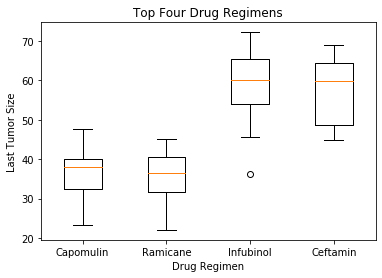

In [15]:
top_four_tumor_size = [top_four['Capomulin']['tumor_volume_mm3'], top_four['Ramicane']['tumor_volume_mm3'], top_four['Infubinol']['tumor_volume_mm3'], top_four['Ceftamin']['tumor_volume_mm3']]
fig, boxs = plt.subplots()
boxs.set_title('Top Four Drug Regimens')
boxs.boxplot(top_four_tumor_size)
plt.xticks([1, 2, 3,4], ['Capomulin', 'Ramicane', 'Infubinol','Ceftamin'])
plt.xlabel("Drug Regimen")
plt.ylabel("Last Tumor Size")
plt.show()

## Line and Scatter Plots

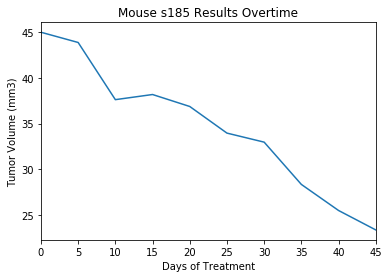

In [16]:
random_capomulin_mouse =  random.choice(pd.unique(top_four['Capomulin']["mouse_id"]))
capomulin_mouse_data=data[data['mouse_id']==random_capomulin_mouse]
capomulin_mouse_data.plot('timepoint', 'tumor_volume_mm3', legend=False)
plt.title(f"Mouse {random_capomulin_mouse} Results Overtime")
plt.xlabel("Days of Treatment")
plt.ylabel("Tumor Volume (mm3)")
plt.show()

['j119'] in green, ['b742'] in red, and ['g316'] in yellow.


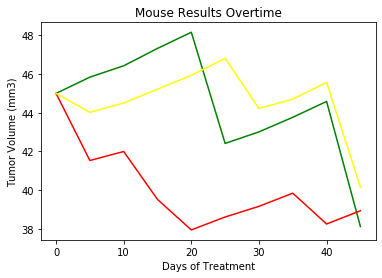

In [17]:
random_capomulin_mouse =  random.choice(pd.unique(top_four['Capomulin']["mouse_id"]))
capomulin_mouse_data=data[data['mouse_id']==random_capomulin_mouse]
random_capomulin_mouse =  random.choice(pd.unique(top_four['Capomulin']["mouse_id"]))
capomulin_mouse_data_two=data[data['mouse_id']==random_capomulin_mouse]
random_capomulin_mouse =  random.choice(pd.unique(top_four['Capomulin']["mouse_id"]))
capomulin_mouse_data_three=data[data['mouse_id']==random_capomulin_mouse]
plt.plot(capomulin_mouse_data["timepoint"], capomulin_mouse_data["tumor_volume_mm3"], color='green')
plt.plot(capomulin_mouse_data_two["timepoint"], capomulin_mouse_data_two["tumor_volume_mm3"], color='red')
plt.plot(capomulin_mouse_data_three["timepoint"], capomulin_mouse_data_three["tumor_volume_mm3"], color='yellow')
plt.title(f"Mouse Results Overtime")
plt.xlabel("Days of Treatment")
plt.ylabel("Tumor Volume (mm3)")
print(f'{capomulin_mouse_data["mouse_id"].unique()} in green, {capomulin_mouse_data_two["mouse_id"].unique()} in red, and {capomulin_mouse_data_three["mouse_id"].unique()} in yellow.')
plt.show()

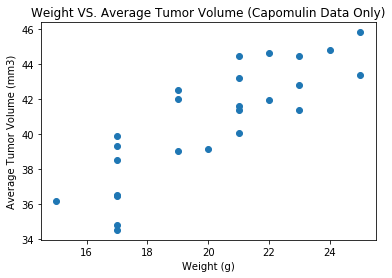

In [18]:
capomulin_data=data[data['drug_regimen']=='Capomulin']
mean_data = capomulin_data.groupby(["drug_regimen","mouse_id"]).mean()
mean_data.reset_index(inplace = True)
weight = mean_data["weight_g"]
mean_volume = mean_data["tumor_volume_mm3"]
plt.scatter(weight, mean_volume)
plt.title("Weight VS. Average Tumor Volume (Capomulin Data Only)")
plt.xlabel("Weight (g)")
plt.ylabel("Average Tumor Volume (mm3)")
plt.show()

## Correlation and Regression


**
 -----------------------
|Correlation Coefficient|
 -----------------------
    --Mean Tumor Volume: 0.8419363424694718
    --Final Tumor Volume: 0.8767060403658119

 -----------------------
|Linear Regression Model|
 -----------------------
    --Mean Tumor Volume: y=0.95x + 21.55
    --Final Tumor Volume: y=1.75x + 1.45
**



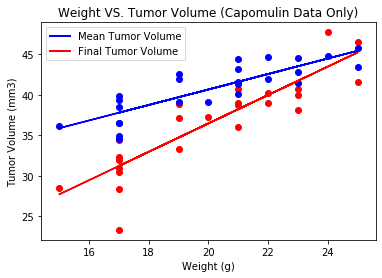

In [63]:
final_volume = last_tumor_volume_four[last_tumor_volume_four['drug_regimen']=='Capomulin']["tumor_volume_mm3"]
slope_f, intercept_f, correlation_coefficient_f, na_one_f, na_two_f = linregress(weight, final_volume)
linear_regression_data_f = weight * slope_f + intercept_f
plt.scatter(weight, final_volume, color='red')
plt.plot(weight, linear_regression_data_f, "r-", color='red')
slope, intercept, correlation_coefficient, na_one, na_two = linregress(weight, mean_volume)
linear_regression_data = weight * slope + intercept
plt.scatter(weight, mean_volume, color='blue')
plt.plot(weight,linear_regression_data,"r-", color='blue')
plt.title("Weight VS. Tumor Volume (Capomulin Data Only)")
plt.xlabel("Weight (g)")
plt.ylabel("Tumor Volume (mm3)")
custom_lines = [Line2D([0], [0], color='blue', lw=2),
                Line2D([0], [0], color='red', lw=2)]
plt.legend(custom_lines, ['Mean Tumor Volume', 'Final Tumor Volume'])

print(
f'''
**
 -----------------------
|Correlation Coefficient|
 -----------------------
    --Mean Tumor Volume: {correlation_coefficient}
    --Final Tumor Volume: {correlation_coefficient_f}

 -----------------------
|Linear Regression Model|
 -----------------------
    --Mean Tumor Volume: y={round(slope,2)}x + {round(intercept, 2)}
    --Final Tumor Volume: y={round(slope_f,2)}x + {round(intercept_f, 2)}
**
'''
)



plt.show()